In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Importing library

In [2]:
import sys
sys.path.append("../../")

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "/home/paperspace/data/MO444_dogs/"

%ls {PATH}

models/  test/  tmp/  train/  val/


# References

Full reference : 
- Lesson 1 of fastai v2; 
- Lesson 2 of fast ai v2;
                  
A summary of the key concepts from a student who take the course:
https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-2-eeae2edd2be4

Wiki of lesson 2: 
http://forums.fast.ai/t/wiki-lesson-2/9399

Jeremy explaining this whole notebook (20min):

https://youtu.be/JNxcznsrRb8?t=1h16m37s


Quick steps:

1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1–2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2–3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer. Rule of thumb: 10x for ImageNet like images, 3x for satellite or medical imaging
7. Use lr_find() again (Note: if you call lr_find having set differential learning rates, what it prints out is the learning rate of the last layers.)
8. Train full network with cycle_mult=2 until over-fitting

# Creating class folders

It is required that all images inside the train and valid folder have to be in sub-folders with title representing the class it belongs. 



In [11]:
tr_path  = os.listdir(f"{PATH}train/")
val_path = os.listdir(f"{PATH}val/")

In [12]:
len(tr_path),len(val_path)

(8302, 6024)

In [13]:
def create_classes_dir(path,l_path):
    for i in range(83):
        if i< 10:
            cl_files = [f for f in l_path if f"0{i}_" in f]

            for img_path in cl_files:
                os.renames(f"{path}{img_path}",f"{path}cl_0{i}/{img_path}")

        else:
            cl_files = [f for f in l_path if f"{i}_" in f]
            for img_path in cl_files:
                os.renames(f"{path}{img_path}",f"{path}cl_{i}/{img_path}")

In [14]:
create_classes_dir(PATH+"train/",tr_path)
create_classes_dir(PATH+"val/",val_path)

**Transforms**

In [5]:
sz= 224; bs= 24;

arch = resnet34 # Object that encapsulate the resnet34 architecture with choice for ImageNet weights.

In [6]:
# You can check on transform.py file that it already applys the normalization on the images,
# based on the Std and Mean of ImageNet

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [7]:
# Create Dataset Class with comes with different methods

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs,val_name="val")

**Analysing size of images**

In [8]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

row_sz, col_sz = list(zip(*size_d.values()))

row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [9]:
row_sz[:5]

array([241, 216, 500, 200, 500])

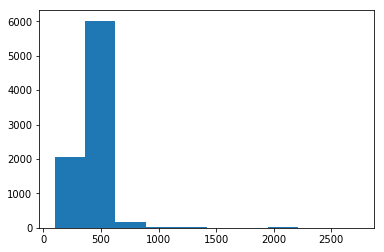

In [10]:
# We can see that the vast majority of images are around 500 pixels
plt.hist(row_sz);

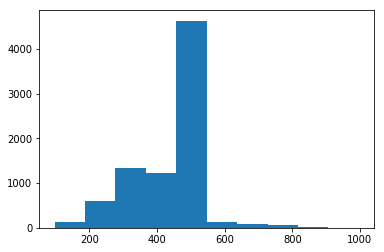

In [11]:
plt.hist(row_sz[row_sz<1000]);

# Visualizing some dogs

In [12]:
fn = PATH + data.trn_ds.fnames[204];
fn

'/home/paperspace/data/MO444_dogs/train/cl_02/02_0044.jpg'

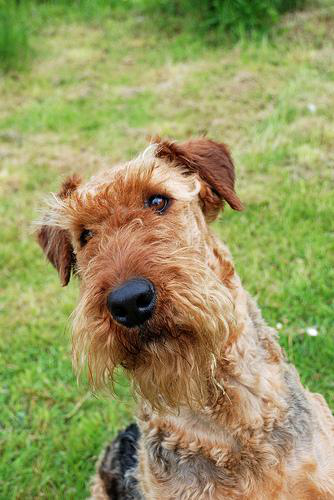

In [13]:
img = PIL.Image.open(fn); img

In [14]:
imgs = []
for i in range(7):
    imgs.append(Image.open(PATH + data.trn_ds.fnames[100*i +1]))

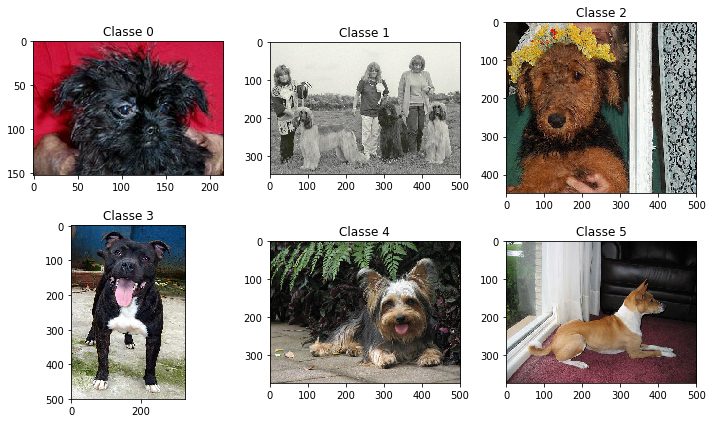

In [15]:
fig = plt.figure()

fig.set_figheight(6)
fig.set_figwidth(10)


ax1 = fig.add_subplot(2,3,1)
ax1.imshow(imgs[0])
ax1.set_title('Classe 0')

ax2 = fig.add_subplot(2,3,2)
ax2.imshow(imgs[1]) 
ax2.set_title('Classe 1')

ax3 = fig.add_subplot(2,3,3)
ax3.imshow(imgs[2])  
ax3.set_title('Classe 2')

ax4 = fig.add_subplot(2,3,4)
ax4.imshow(imgs[3])
ax4.set_title('Classe 3')

ax5 = fig.add_subplot(2,3,5)
ax5.imshow(imgs[4]) 
ax5.set_title('Classe 4')

ax6 = fig.add_subplot(2,3,6)
ax6.imshow(imgs[5])  
ax6.set_title('Classe 5')
plt.tight_layout()
plt.show()

# Initial model

In [16]:
# Creating a function to work with different sizes of image easily.
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
                           max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs,val_name="val")
    return data #if sz>300 else data.resize(340, 'tmp')

In [17]:
data = get_data(224,32)

In [18]:
learn = ConvLearner.pretrained(arch,data, precompute=True)

In [19]:
lrf=learn.lr_find()

 85%|████████▌ | 221/260 [00:03<00:00, 68.64it/s, loss=12.6]


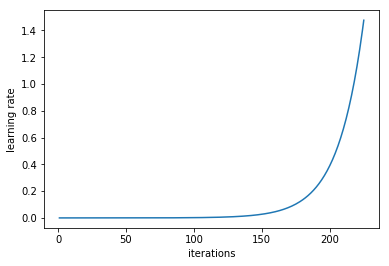

In [20]:
learn.sched.plot_lr()

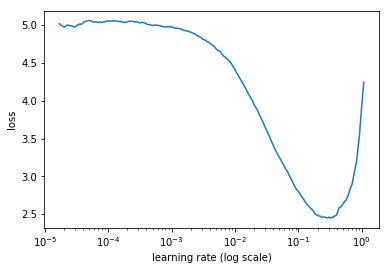

In [21]:
learn.sched.plot()

From this graph we take 0.01 as LR .

# Precompute

In [22]:
# Precompute is just for training the last layer ( Last layer of Dense ANN not the entire classifier)

learn = ConvLearner.pretrained(arch,data, precompute=True)

learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                     
    0      0.875256   0.45219    0.880771  
    1      0.554138   0.387808   0.887247                    
    2      0.453426   0.371897   0.889073                    
    3      0.37985    0.362818   0.891896                     
    4      0.33696    0.355239   0.894553                     



[array([0.35524]), 0.894553304569779]

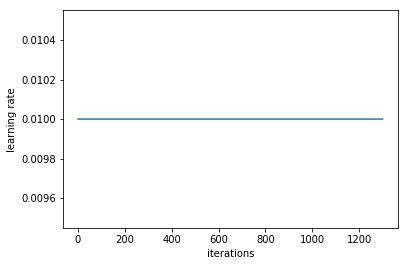

In [23]:
learn.sched.plot_lr()

In [24]:
learn.precompute = False  # Training the Whole Calssifier (Dense part only)
learn.fit(1e-2, 5, cycle_len=1) # Check out the explnation of Cyclical learning rate
                                # https://youtu.be/JNxcznsrRb8?t=30m15s

epoch      trn_loss   val_loss   accuracy                    
    0      0.414935   0.325645   0.89721   
    1      0.372207   0.323114   0.900531                    
    2      0.371065   0.317883   0.901528                    
    3      0.365774   0.319647   0.902026                    
    4      0.330475   0.314977   0.90103                     



[array([0.31498]), 0.9010295583060792]

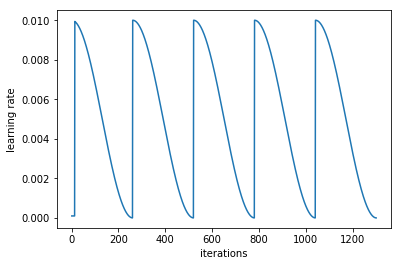

In [25]:
learn.sched.plot_lr()

Underfitting :  val_loss < trn_loss,  then:

**Increase Cycle mult**

In [26]:
learn.fit(1e-2, 3, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.34787    0.318365   0.900033  
    1      0.343984   0.320415   0.899867                    
    2      0.312603   0.309709   0.904351                    
    3      0.341651   0.322265   0.89555                     
    4      0.310578   0.315471   0.901528                    
    5      0.296109   0.30849    0.904351                    
    6      0.298361   0.306732   0.904849                    



[array([0.30673]), 0.9048488874326153]

Why 7 epochs ? Cycle_len =1 which means each cycle is 1 epoch. Then we adjusted cycle_mult= 2 so it multiplies the last cycle by two ( 1st cycle is 1 epoch, 2nd cycle is 2 epochs, and 3rd cycle is 4 epochs )

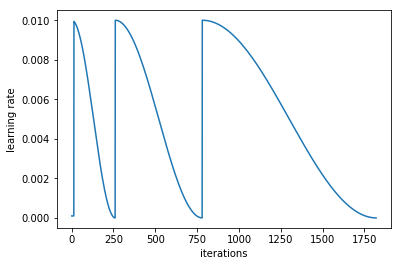

In [28]:
learn.sched.plot_lr()

In [29]:
learn.save("224_pre") # Save weights.

# Increase size of images

In [30]:
learn.set_data(get_data(290,bs-2))

In [31]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.340467   0.274604   0.915477  
    1      0.345223   0.275655   0.912488                    
    2      0.286264   0.275144   0.91365                     
    3      0.387394   0.296323   0.906343                    
    4      0.335982   0.280016   0.910329                    
    5      0.297327   0.269964   0.915477                    
    6      0.265543   0.268644   0.915975                    



[array([0.26864]), 0.9159747597902805]

In [32]:
learn.save("290_pre") # Save weights.

In [33]:
learn.set_data(get_data(320,bs))

learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.263734   0.273614   0.911657  
    1      0.267617   0.27928    0.914314                    
    2      0.23846    0.273334   0.914314                    
    3      0.27028    0.299348   0.908004                    
    4      0.253469   0.277769   0.913982                    
    5      0.207416   0.271292   0.91448                     
    6      0.216316   0.273896   0.914314                    



[array([0.2739]), 0.9143141785637163]

## Fine-tuning and differential learning rate annealing

Question: Difference between precompute=True and unfreeze?

- We started with a pre-trained network
- We added a couple of layers on the end of it which start out random. With everything frozen and precompute=True, all we are learning is the layers we have added.
- With precompute=True, data augmentation does not do anything because we are showing exactly the same activations each time.
- We then set precompute=False which means we are still only training the layers we added because it is frozen but data augmentation is now working because it is actually going through and recalculating all of the activations from scratch.
- Then finally, we unfreeze which is saying “okay, now you can go ahead and change all of these earlier convolutional filters”.

In [43]:
learn.load("290_pre")

In [40]:
learn.unfreeze()

In [44]:
lr_ar=np.array([1e-5,1e-4,1e-2])

In [45]:
learn.fit(lr_ar, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.433978   0.311355   0.902192  
    1      0.407139   0.306559   0.900863                    
    2      0.347286   0.286009   0.909665                    
    3      0.372046   0.299764   0.906343                    
    4      0.315488   0.289059   0.911657                    
    5      0.280139   0.288236   0.914148                    
    6      0.257814   0.279821   0.915809                    


[array([0.27982]), 0.9158087017448271]

We got some improvement here 0.27982 > 0.2739 Let's save the weights and train more ! 

In [46]:
learn.save("320_finetun") # The images still 320

In [47]:
learn.fit(lr_ar, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.263998   0.289788   0.91282   
    1      0.287558   0.29395    0.909831                    
    2      0.250832   0.294338   0.910827                    
    3      0.268835   0.303002   0.909997                    
    4      0.214753   0.297619   0.909831                    
    5      0.207493   0.285974   0.915809                    
    6      0.207782   0.289528   0.913318                    


[array([0.28953]), 0.9133178341907348]

No further improvements, but  we could try another type of ***transformations or zoom sizes*** on the tfms_from_model() in the get_data() function.

# TTA 

In [49]:
learn.load("320_finetun") 

In [50]:
from sklearn.metrics import log_loss

log_preds, y = learn.TTA() # For each Val/Test image is created 4 transformed images ( 4 = > default)
probs = np.mean(np.exp(log_preds),0) # Calculate the mean of the probabiliteis of the 4 images

In [51]:
log_preds.shape

(5, 6022, 83)

In [81]:
??accuracy_np

In [52]:
accuracy_np(probs, y)

0.920292261707074

# Analyzing results

In [53]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [54]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score

In [55]:
f1_score(y,preds,average='macro') # Macro was chose because all the classes are balanced. 
                                  # 73 images for each class on the val set 

0.9163367681315315

In [56]:
accuracy_score(y,preds,normalize=True)

0.920292261707074

In [57]:
cm = confusion_matrix(y, preds)

In [58]:
cm # too many classes :/

array([[ 48,   0,   0, ...,   0,   0,   0],
       [  0, 135,   0, ...,   0,   0,   0],
       [  0,   0,  96, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  46,   0,   0],
       [  0,   0,   0, ...,   0,  47,   0],
       [  0,   0,   0, ...,   0,   0,  47]])